In [6]:
import matplotlib.pyplot as plt
import numpy as np
# import scipy.ndimage
import pandas as pd
from scipy.ndimage import gaussian_filter1d as gsmooth
from scipy.optimize import curve_fit

from tools.file_finder import find_file
import tools.helpers as tools

In [12]:
date0 = "210512"
date1 = "210609"

files = [
    find_file("T1", 1, date0, raw=True),
    find_file("T1", 2, date0, raw=True),
    find_file("T1", 3, date0, raw=True),
    find_file("T1", 6, date1, raw=True),
    find_file("T1", 7, date1, raw=True),
    find_file("T1", 127, "211026", raw=True),
]

data_all = [
    pd.read_csv(f, skiprows=20, names=['time', 'counts'], delimiter='\t') for f in files
]

for d in data_all:
    d['smooth'] = gsmooth(d.counts, sigma=5)

titles = [f[-30:] for f in files]

Caching...
Done.


In [33]:
first_pulse, last_pulse = 20, 20

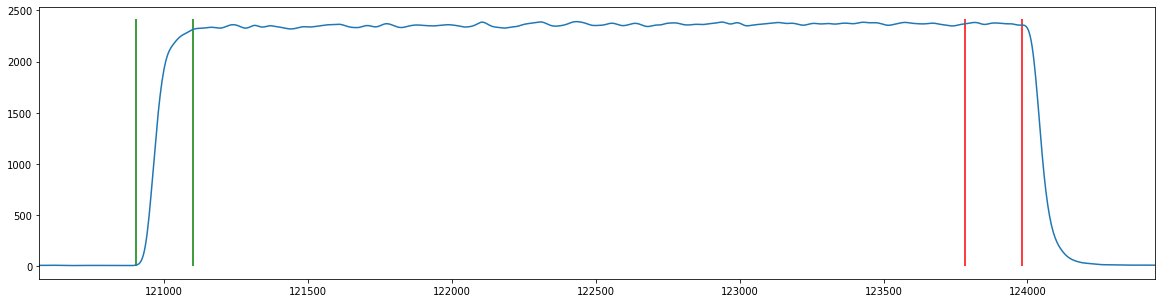

In [34]:
data_col = 'smooth' # 'counts' or 'smooth'

max_counts = np.array([max(data[data_col]) for data in data_all])

COUNTS_THRESHOLD = 0.5 # * the max number of counts in any bin

ris_fals = [
    tools.get_rise_falls(np.array(data[data_col]), thresh) 
    for data, thresh in zip(data_all, COUNTS_THRESHOLD*max_counts)
]
rises = [rf[0] for rf in ris_fals]
falls = [rf[1] for rf in ris_fals]

rise_ts = [np.array(data.time[r]) for data, r in zip(data_all, rises)]
fall_ts = [np.array(data.time[f]) for data, f in zip(data_all, falls)]

################################################################
integration_width_ns = 200 # ns
# TODO [DONE?] FIx this make it dependent on step size 
dt = np.array([spec.time[1] - spec.time[0] for spec in data_all])
integration_width = (integration_width_ns // dt).astype(int)
# integration_width

forwards_shift = -20
backwards_shift = -20
################################################################

def get_readout_start_and_ends(rise_ts, fall_ts):
    """ Assumes that the first rise and fall are always 
    from the same readout pulse. """
    fin_len = min(len(rise_ts), len(fall_ts))
    result = np.zeros((fin_len, 2))
    result[:,0] = rise_ts[:fin_len]
    result[:,1] = fall_ts[:fin_len]
    return result

f = True
start_ends = [] # pairs of pulse start and end times
start_ends_idx = []
for i,(spec, s_rises, s_falls, s_rise_ts, s_fall_ts) in enumerate(zip(
        data_all, rises, falls, rise_ts, fall_ts)):
    start_end = get_readout_start_and_ends(s_rise_ts, s_fall_ts)
    start_end_idx = get_readout_start_and_ends(s_rises, s_falls)
    start_ends.append(start_end)
    start_ends_idx.append(start_end_idx)
if f:
    plt.figure(figsize=(20, 5))
    plt.plot(spec.time, spec[data_col])
    top = max(spec[data_col])
    plt.vlines(forwards_shift*dt[i] + s_rise_ts, 0, top, "green")
    plt.vlines(forwards_shift*dt[i] + s_rise_ts + dt[i]*integration_width[i], 0, top, "green")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts, 0, top, "red")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts - dt[i]*integration_width[i], 0, top, "red")
    # plt.xlim(0, s_fall_ts[5])
    plt.xlim(s_rise_ts[first_pulse]-400, s_fall_ts[last_pulse]+400)
    f = False
    plt.show()


# readout_counts = np.array(data.counts)[[pulses[:, 0]: pulses[:, 0] + integration_width]] 
take_previous_fall = False # If false, use the fall of the same pulse as the reference signal
spec_tau_axes = []
PL_reads = []
PL_refs = []
for (spec, start_end, start_end_idx, int_width) in zip(
        data_all, start_ends, start_ends_idx, integration_width):
    forward_t = np.arange(int_width)
    x = take_previous_fall * 1 # Scan the arrays in a fashion that depends on this setting
    forward = np.tile(forward_t, (len(start_end_idx)-x, 1)) 
    backward = -forward
    forward += forwards_shift
    backward += backwards_shift
    reads = (forward + start_end_idx[x:, [0]]).astype(int)
    refs = (backward + start_end_idx[:len(start_end_idx)-x, [1]]).astype(int)

    tau = start_end[1:, 0] - start_end[:-1, 1]
    # if not take_previous_fall ignore the first pulse
    reads = reads[1-x:]
    refs  = refs[1-x:]

    arr = np.array(spec.counts)
    reads = np.sum(arr[reads], axis=-1)
    refs  = np.sum(arr[refs], axis=-1)

    spec_tau_axes.append(tau)
    PL_reads.append(reads)
    PL_refs.append(refs)

\data_dump/210512_T1_1_raw.txt I_inf:0.54 T1:1000000.00 C1:0.19 beta:1.00
\data_dump/210512_T1_2_raw.txt I_inf:0.59 T1:289014.40 C1:0.12 beta:0.60
\data_dump/210512_T1_3_raw.txt I_inf:0.60 T1:308371.30 C1:0.07 beta:0.60
\data_dump/210609_T1_6_raw.txt I_inf:0.65 T1:16874.94 C1:0.02 beta:1.00
\data_dump/210609_T1_7_raw.txt I_inf:0.65 T1:12599.63 C1:0.03 beta:0.60
ata_dump/211026_T1_127_raw.txt I_inf:0.63 T1:453222.27 C1:0.00 beta:1.00


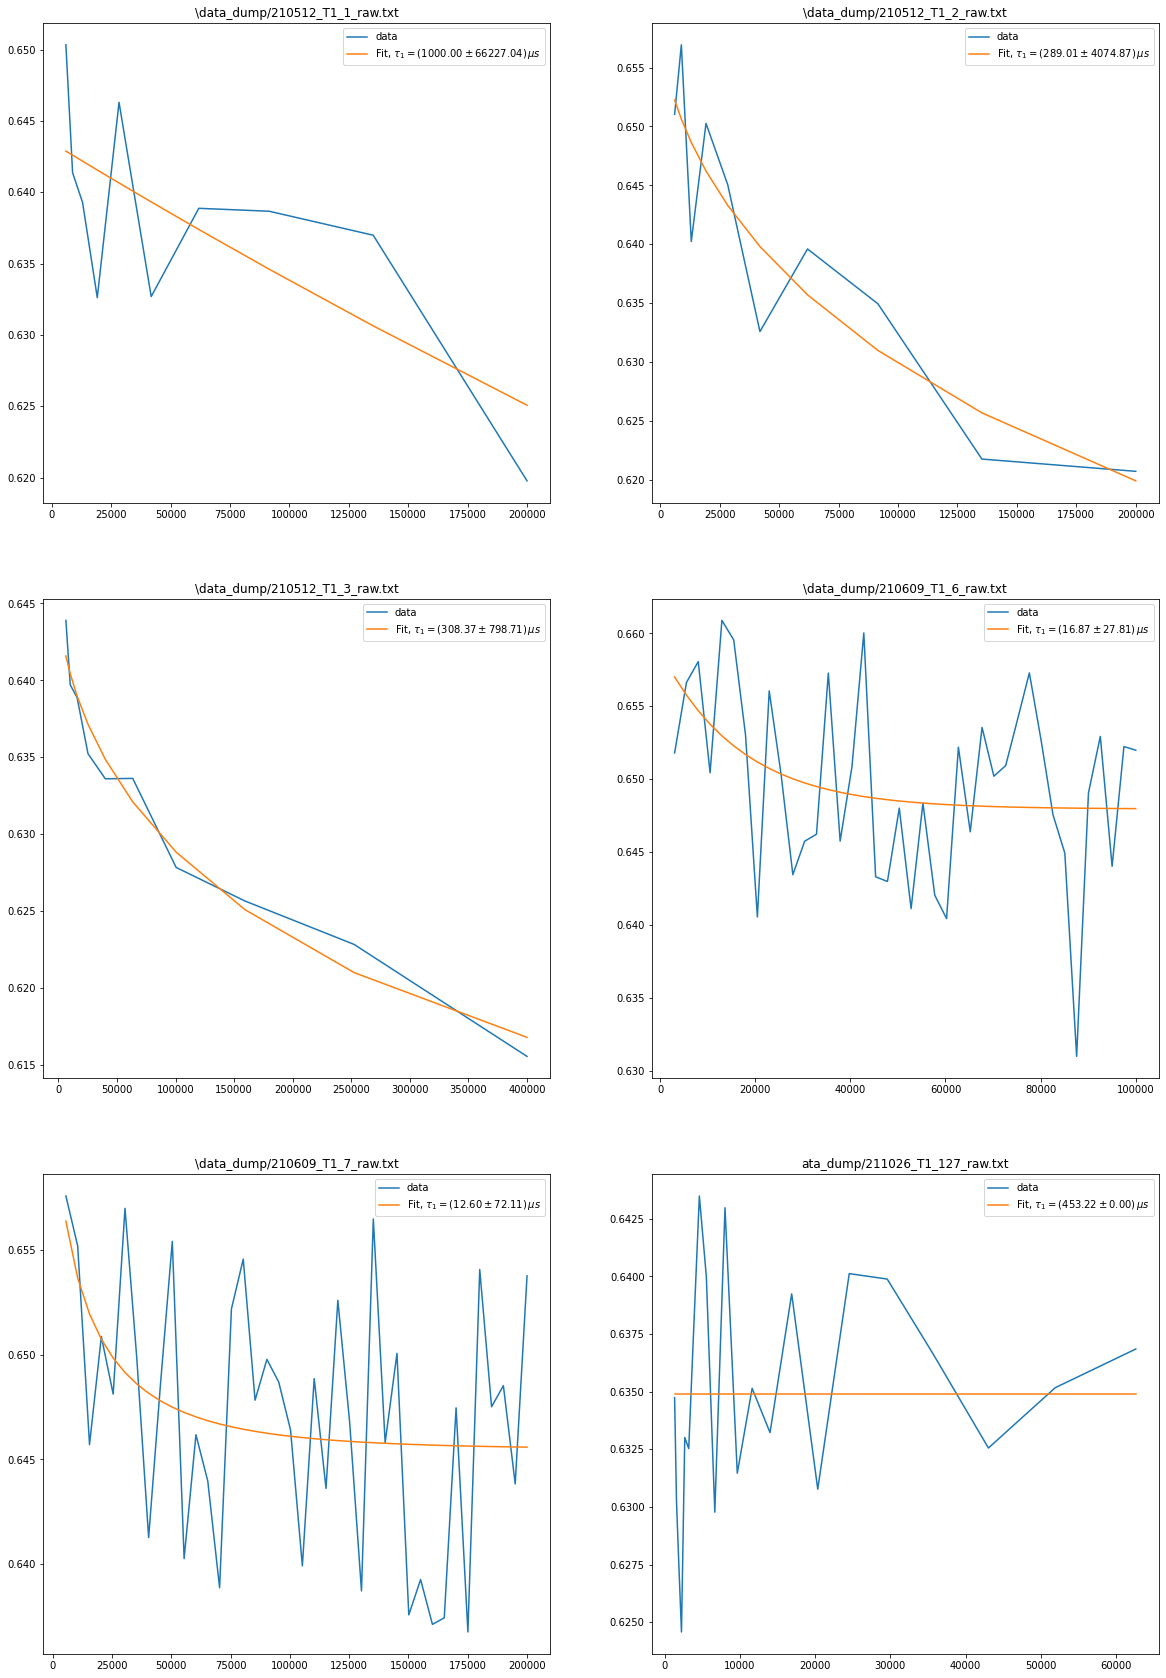

In [28]:
fig = plt.figure(figsize=(20, 30))
n_cols = 2
axes = fig.subplots(
    nrows=(len(titles)+n_cols-1)//n_cols, 
    ncols=n_cols,
    sharex="none").flatten()

def func(t, tau, C):
    return np.exp(-t/tau) + C

def func2(tau, I_inf, T1, C1, beta=0.7, TM=1, CM=0):
    return I_inf * (1 + C1*np.exp(-((tau/T1)**beta)) - CM*np.exp(-tau/TM) )

inits = {
    'tau': 100000,
    'C': 0.9
}

inits2 = np.array([
    # name    init  lower  upper
    ['I_inf', 0.9,  0.,    1.],
    ['T1',    1e5,  1e3,   1e6],
    ['C1',    0.5,  0.,    1.],
    ['beta',  0.7,  0.6,   1],
    # ['TM',    200,  100,   300],
    # ['CM',    0.1,  0.,    1.], 
], dtype=object)

init_vals = list(inits2[:,1])

for title, tau, reads, refs, ax in zip(titles, spec_tau_axes, PL_reads, PL_refs, axes):
    offset = 1 + 1 # offset should be 2, the first pulse and every odd pulse should be excluded
    tau   = tau[offset::2]
    reads = reads[offset::2]
    refs  = refs[offset::2]
    fit, err = curve_fit(
        func2, tau, reads/refs, init_vals, bounds=(inits2[:,2], inits2[:,3])
        )
    err = np.sqrt(np.diag(err))
    # reads -= min(reads)
    # refs -= min(refs)
    # reads = gsmooth(reads, 3)
    ax.plot(tau, (reads / refs), label="data")# - min(reads/refs))
    ax.plot(tau, func2(tau, *fit), label=rf"Fit, $\tau_1 = ({fit[1]/1e3:.2f} \pm {err[1]/1e3:.2f})\,\mu s$")
    print(title, *[f"{x}:{p:.2f}" for x, p in zip(inits2[:,0], fit)])
    
    # ax.set_yscale("log")
    ax.legend()
    ax.set_title(title)
